<h1> Imports

In [1]:
'''
Code to run Reptile, following Ocariz's notebooks in the Reptile folder
Note, utils kept here b/c of use of globals (issues when run from files)
Probabilistic variant to enable uncertainty quantification
Uses a mixture model, as per Ocariz's code
'''

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns 
from math import pi as PI
import random
# !pip3 install higher
import torch.nn as nn
import torch
import random
from higher import innerloop_ctx
import warnings
import math

# import backbone model, dataset, and code utils
from models import Neural_Network, Prob_Neural_Network, Prob_Mixture_Neural_Network
from constants import *
import analysis_utils
# pull from dataset specifically for corrupted noise
from data_complex_noise_dual import *

Available device: cpu


<h1> Helper functions

In [2]:
#https://towardsdatascience.com/predicting-probability-distributions-using-neural-networks-abef7db10eac
def loss_gaussian(prediction,label,number_of_gaussians=4):
    epsilon = 1e-20 #avoid division by 0
    avoid_inf = 1e-20
    number_of_gaussians=number_of_gaussians*3
    loss = avoid_inf
    means = prediction[:,0:int(number_of_gaussians/3)] 
    stds = prediction[:,int(number_of_gaussians/3):int(2*number_of_gaussians/3)]
    weights = prediction[:,int(2*number_of_gaussians/3):number_of_gaussians]
    for i in range(int(number_of_gaussians/3)):
        mean = means[:,i]
        std = stds[:,i]
        weight = weights[:,i]
        a = 1/(torch.sqrt(2*math.pi*std**2)+epsilon)
        b = -((label-mean)**2)/(2*std**2+epsilon)
        loss = loss + weight*a*torch.exp(b)
    return torch.mean(-torch.log(loss))

criterion = loss_gaussian

def copy_existing_model(model):
    # Function to copy an existing model
    # We initialize a new model
    new_model = Prob_Mixture_Neural_Network()
    # Copy the previous model's parameters into the new model
    new_model.load_state_dict(model.state_dict())
    return new_model

def get_samples_in_good_format(wave, num_samples=10, with_noise=False, noise_dev=1, input_range=[-5.0, 5.0]):
    #This function is used to sample data from a wave
    sample_data = wave.get_samples(num_samples=num_samples,with_noise=with_noise, noise_dev=noise_dev,
                        min_query_x=input_range[0], max_query_x=input_range[1])
    x = sample_data["input"]
    y_true = sample_data["output"]
    # We add [:,None] to get the right dimensions to pass to the model: we want K x 1 (we have scalars inputs hence the x 1)
    # Note that we convert everything torch tensors
    x = torch.tensor(x[:,None])
    y_true = torch.tensor(y_true[:,None])
    return x,y_true

def initialization_to_store_meta_losses():
  # This function creates lists to store the meta losses
  global store_train_loss_meta; store_train_loss_meta = []
  global store_test_loss_meta; store_test_loss_meta = []

def test_set_validation(model,new_model,wave,lr_inner,k,store_test_loss_meta, num_samples=10, with_noise=False, noise_dev=1, input_range=[-5.0, 5.0], extract_task_info=False):
    # This functions does not actually affect the main algorithm, it is just used to evaluate the new model
    new_model,losses,task_info = training(model, wave, lr_inner, k, num_samples=num_samples, with_noise=with_noise, noise_dev=noise_dev, input_range=input_range,extract_task_info=extract_task_info)
    # Obtain the loss
    loss = evaluation(new_model, wave, num_samples=num_samples, with_noise=with_noise, noise_dev=noise_dev, input_range=input_range)
    # Store loss
    store_test_loss_meta.append(loss)
    return losses, task_info

def train_set_evaluation(new_model,wave,store_train_loss_meta, num_samples=10, with_noise=False, noise_dev=1, input_range=[-5.0, 5.0]):
    loss = evaluation(new_model, wave, num_samples=num_samples, with_noise=with_noise, noise_dev=noise_dev, input_range=input_range)
    store_train_loss_meta.append(loss) 

def print_losses(epoch,store_train_loss_meta,store_test_loss_meta,printing_step=1000):
  if epoch % printing_step == 0:
    print(f'Epochh : {epoch}, Average Train Meta Loss : {np.mean(store_train_loss_meta)}, Average Test Meta Loss : {np.mean(store_test_loss_meta)}')

#This is based on the paper update rule, we calculate the difference between parameters and then this is used by the optimizer, rather than doing the update by hand
def reptile_parameter_update(model,new_model):
  # Zip models for the loop
  zip_models = zip(model.parameters(), new_model.parameters())
  for parameter, new_parameter in zip_models:
    if parameter.grad is None:
      parameter.grad = torch.tensor(torch.zeros_like(parameter))
    # Here we are adding the gradient that will later be used by the optimizer
    parameter.grad.data.add_(parameter.data - new_parameter.data)

# Define commands in order needed for the metaupdate
# Note that if we change the order it doesn't behave the same
def metaoptimizer_update(metaoptimizer):
  # Take step
  metaoptimizer.step()
  # Reset gradients
  metaoptimizer.zero_grad()

def metaupdate(model,new_model,metaoptimizer):
  # Combine the two previous functions into a single metaupdate function
  # First we calculate the gradients
  reptile_parameter_update(model,new_model)
  # Use those gradients in the optimizer
  metaoptimizer_update(metaoptimizer)

def evaluation(new_model, wave, item = True, num_samples=10, with_noise=False, noise_dev=1, input_range=[-5.0, 5.0]):
    # Get data
    x, label = get_samples_in_good_format(wave, num_samples=num_samples, with_noise=with_noise, noise_dev=noise_dev, input_range=input_range)
    # Make model prediction
    prediction = new_model(x)
    # Get loss
    if item == True: #Depending on whether we need to return the loss value for storing or for backprop
      loss = criterion(prediction,label).item()
    else:
      loss = criterion(prediction,label)
    return loss

def training(model, wave, lr_k, k, num_samples=10, with_noise=False, noise_dev=1, input_range=[-5.0, 5.0], extract_task_info=False):
    # Create new model which we will train on
    new_model = copy_existing_model(model)
    # Define new optimizer
    koptimizer = torch.optim.SGD(new_model.parameters(), lr=lr_k)
    # Update the model multiple times, note that k>1 (do not confuse k with K)
    losses = []
    task_info = {}
    for i in range(k):
        # Reset optimizer
        koptimizer.zero_grad()
        # Evaluate the model
        loss = evaluation(new_model, wave, item = False, num_samples=num_samples, with_noise=with_noise, noise_dev=noise_dev, input_range=input_range)
        # Backpropagate
        loss.backward()
        koptimizer.step()
        losses.append(loss.item())
    return new_model, losses, task_info

def eval_for_plotting(model,wave,lr_inner,k, num_samples=10, with_noise=False, noise_dev=1, input_range=[-5.0, 5.0], extract_task_info=False):
    
    # get samples 
    x, label = get_samples_in_good_format(wave, num_samples=num_samples, with_noise=with_noise, noise_dev=noise_dev, input_range=input_range)
    
    # Create new model which we will train on
    new_model = copy_existing_model(model)
    
    # Define new optimizer
    koptimizer = torch.optim.SGD(new_model.parameters(), lr=lr_k)
    
    losses = []
    task_info = {}
    
    # store for plotting and analysis
    if extract_task_info == True: 
        input_coords = x.detach().numpy()[:,0]
        true_vals = sorted([(x, y) for (x, y) in zip(input_coords, label)], key=lambda x: x[0])
        
        task_info["input_coords"] = input_coords
        task_info["gt"] = true_vals
        
        # generate more points for a fine-grained evaluation of underlying func
        eval_x, eval_true_y = get_samples_in_good_format(wave,num_samples=10000, input_range=input_range)
        
        eval_coords = eval_x.detach().numpy()[:,0]
        task_info["eval_coords"] = eval_coords
        task_info["gt_func"] = sorted([(x, y) for (x, y) in zip(eval_coords, eval_true_y)], key=lambda x: x[0])
    
        
    for grad_step in range(k):
        
        if extract_task_info: 
                # use preds for new points
                preds_eval = new_model(eval_x)
                task_preds = preds_eval#preds_eval.detach().numpy()[:,0]
                pred_mu = preds_eval[0].detach().numpy()[:,0]
                pred_std = preds_eval[1].detach().numpy()[:,0]
                pred_data = sorted([(x, mu, std) for (x, mu, std) in zip(eval_coords, pred_mu, pred_std)], key=lambda x: x[0])
                task_info[f"preds_{grad_step}"] = pred_data
        
        # Reset optimizer
        koptimizer.zero_grad()
        # Evaluate the model
        loss = evaluation(new_model, wave, item = False, num_samples=num_samples, with_noise=with_noise, noise_dev=noise_dev, input_range=input_range)
        # Backpropagate
        loss.backward()
        koptimizer.step()
        losses.append(loss.item())
    return losses, task_info

<h1> Reptile

In [3]:
#Define important variables
epochs = int(1e5) 
lr_meta=0.001 # Learning rate for meta model (outer loop)
printing_step=1000 # how many epochs should we wait to print the loss
lr_k=0.01 # Internal learning rate
k=5 # Number of internal updates for each task

# Initializations
initialization_to_store_meta_losses()
model = Prob_Mixture_Neural_Network()
metaoptimizer = torch.optim.Adam(model.parameters(), lr=lr_meta)

In [4]:
'''
Create dataset
'''
# specify the number of tasks to sample per meta-set
# note: we end up sampling tasks at random, so sizes are not particularly relevant
# artifact of the way we structured the dataset earlier 
meta_train_size=10000
meta_val_size=1000
meta_test_size=1000
meta_train_eval_size = 20

dataset = RegressionDomain(amp_min=amp_min, amp_max=amp_max, 
                           phase_min=phase_min, phase_max=phase_max, 
                           train_size=meta_train_size, val_size=meta_val_size, test_size=meta_test_size)

meta_val_set = dataset.get_meta_val_batch()
meta_test_set = dataset.get_meta_test_batch()

In [5]:
# specify noise during training
num_samples=10
with_noise=True
noise_dev=1.0
input_range=[-5.0, 5.0]


# Training loop
for epoch in range(epochs):
        
    # Sample a sine wave (Task from training data)
    wave = dataset.get_meta_train_batch(task_batch_size=1)

    # Update model predefined number of times based on k
    new_model,_,_ = training(model, wave[0], lr_k, k, num_samples=num_samples, with_noise=with_noise, noise_dev=noise_dev, input_range=input_range)

    # Evalaute the loss for the training data
    train_set_evaluation(new_model,wave[0],store_train_loss_meta, num_samples=num_samples, with_noise=with_noise, noise_dev=noise_dev, input_range=input_range)     
    
    #Meta-update --> Get gradient for meta loop and update
    metaupdate(model,new_model,metaoptimizer)
    
    # Evalaute the loss for the test data
    # Note that we need to sample the wave from the test data
    wave = dataset.get_meta_val_batch(task_batch_size=1)
    test_set_validation(model,new_model,wave[0],lr_k,k,store_test_loss_meta, num_samples=num_samples, with_noise=with_noise, noise_dev=noise_dev, input_range=input_range)

    # Print losses every 'printing_step' epochs
    print_losses(epoch,store_train_loss_meta,store_test_loss_meta,printing_step)

<ipython-input-2-d74246e4c852>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x[:,None])
<ipython-input-2-d74246e4c852>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(y_true[:,None])
/Users/kcollins/mlmi4_MAML_reproduce/models.py:126: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = self.softmax(x[:,int(2*self.output_size/3):self.output_size])
<ipython-input-2-d74246e4c852>:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourc

Epochh : 0, Average Train Meta Loss : 2.0323715209960938, Average Test Meta Loss : 3.271444320678711
Epochh : 1000, Average Train Meta Loss : 1.8164843664124057, Average Test Meta Loss : 1.874635420694992
Epochh : 2000, Average Train Meta Loss : 1.822005880662407, Average Test Meta Loss : 1.8556659023264894
Epochh : 3000, Average Train Meta Loss : 1.822461635797908, Average Test Meta Loss : 1.8604830306635345
Epochh : 4000, Average Train Meta Loss : 1.8192864298537443, Average Test Meta Loss : 1.8559448836565435
Epochh : 5000, Average Train Meta Loss : 1.8227109899224818, Average Test Meta Loss : 1.853223835747377
Epochh : 6000, Average Train Meta Loss : 1.8195464069138882, Average Test Meta Loss : 1.8409297652511551
Epochh : 7000, Average Train Meta Loss : 1.8122568033915505, Average Test Meta Loss : 1.8281409573280851
Epochh : 8000, Average Train Meta Loss : 1.8016529392255844, Average Test Meta Loss : 1.8188140068367102
Epochh : 9000, Average Train Meta Loss : 1.7946350176516748, Av

Epochh : 78000, Average Train Meta Loss : 1.6624849011430591, Average Test Meta Loss : 1.6854315830066995
Epochh : 79000, Average Train Meta Loss : 1.6618639574060132, Average Test Meta Loss : 1.6848371982996946
Epochh : 80000, Average Train Meta Loss : 1.6615696485982971, Average Test Meta Loss : 1.684108217806376
Epochh : 81000, Average Train Meta Loss : 1.6612486313149568, Average Test Meta Loss : 1.6833546369099222
Epochh : 82000, Average Train Meta Loss : 1.660984806598156, Average Test Meta Loss : 1.683019717363289
Epochh : 83000, Average Train Meta Loss : 1.6605943632964784, Average Test Meta Loss : 1.6828002208732025
Epochh : 84000, Average Train Meta Loss : 1.6603642825588485, Average Test Meta Loss : 1.6828296373296032
Epochh : 85000, Average Train Meta Loss : 1.6601906469743446, Average Test Meta Loss : 1.6825509983095646
Epochh : 86000, Average Train Meta Loss : 1.6600197344696062, Average Test Meta Loss : 1.6825304896325708
Epochh : 87000, Average Train Meta Loss : 1.65966

In [6]:
torch.save(model.state_dict(), "prob_mixture_reptile_dual.pt")

<h1> Few Shot learning with new meta-model

<ipython-input-2-d74246e4c852>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x[:,None])
<ipython-input-2-d74246e4c852>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(y_true[:,None])


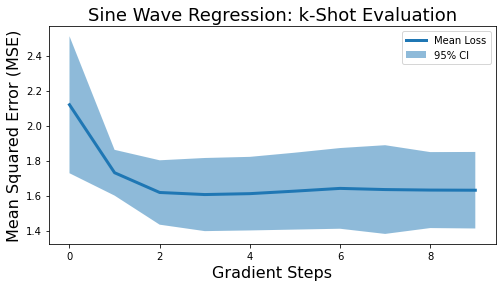

In [7]:
# wave = dataset.get_meta_val_batch(task_batch_size=1)#wave = random.sample(SINE_TEST, 1)
#     test_set_validation(model,new_model,wave[0],lr_k,k,store_test_loss_meta)

all_losses = []
num_eval = 1000
num_k_shots = 10

num_samples=10
with_noise=False
noise_dev=0.001
input_range=[-5.0, 5.0]

test_waves = dataset.get_meta_test_batch(task_batch_size=num_eval)
for test_eval in range(num_eval): 
    test_wave = test_waves[test_eval]
    metaTrainLosses, task_info = test_set_validation(model,new_model,test_wave,lr_k,num_k_shots,store_test_loss_meta, with_noise=with_noise, noise_dev=noise_dev, input_range=input_range)
    all_losses.append(np.array(metaTrainLosses))
    

all_losses = np.array(all_losses)
np.save(f"reptile_sine_{num_k_shots}.npy", all_losses)
    
fig, ax = plt.subplots(figsize=(8,4))

mean_loss = np.mean(all_losses, axis=0)

# confidence interval plotting help from: https://stackoverflow.com/questions/59747313/how-to-plot-confidence-interval-in-python
y = mean_loss
x = list(range(num_k_shots))
ci = 1.96 * np.std(all_losses, axis=0)**2/np.sqrt(len(y))

ax_size=16
title_size=18
                                                  
ax.plot(x, y, linewidth=3, label=f"Mean Loss")
# to avoid having MSE < 0
truncated_error = np.clip(y-ci, a_min=0, a_max=None)
ax.fill_between(x, truncated_error, (y+ci), alpha=.5,label=f"95% CI")

ax.set_xlabel("Gradient Steps",fontsize=ax_size)
ax.set_ylabel("Mean Squared Error (MSE)",fontsize=ax_size)
ax.set_title("Sine Wave Regression: k-Shot Evaluation",fontsize=title_size)
ax.legend()#loc="upper right")
plt.savefig("reptile_sine_wave_reg_kshot_prob_mixture.png")
# ax.set_ylim([0,7])

In [8]:
test_waves = dataset.get_meta_test_batch(task_batch_size=num_eval)
wave = np.random.choice(test_waves, 1)[0]


input_range = [0, 10]
num_mixtures= 4

x, label = get_samples_in_good_format(wave, num_samples=num_samples, with_noise=with_noise, noise_dev=noise_dev, input_range=input_range)

preds = model(x)
print(preds.shape)

mu = preds[:, :num_mixtures].detach().numpy()
std = preds[:, num_mixtures:2*num_mixtures].detach().numpy()
weights = preds[:, 2*num_mixtures:].detach().numpy()

torch.Size([10, 12])


<ipython-input-2-d74246e4c852>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x[:,None])
<ipython-input-2-d74246e4c852>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(y_true[:,None])
/Users/kcollins/mlmi4_MAML_reproduce/models.py:126: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = self.softmax(x[:,int(2*self.output_size/3):self.output_size])


In [9]:
def eval_for_plotting_mixture(model,wave,lr_inner,k, num_samples=10, with_noise=False, noise_dev=1, input_range=[-5.0, 5.0], extract_task_info=False):
    
    # get samples 
    x, label = get_samples_in_good_format(wave, num_samples=num_samples, with_noise=with_noise, noise_dev=noise_dev, input_range=input_range)
    
    # Create new model which we will train on
    new_model = copy_existing_model(model)
    
    # Define new optimizer
    koptimizer = torch.optim.SGD(new_model.parameters(), lr=lr_k)
    
    losses = []
    task_info = {}
    
    num_mixtures = 4
    
    # store for plotting and analysis
    if extract_task_info == True: 
        input_coords = x.detach().numpy()[:,0]
        true_vals = sorted([(x, y) for (x, y) in zip(input_coords, label)], key=lambda x: x[0])
        
        task_info["input_coords"] = input_coords
        task_info["gt"] = true_vals
        
        # generate more points for a fine-grained evaluation of underlying func
        eval_x, eval_true_y = get_samples_in_good_format(wave,num_samples=10000, input_range=input_range)
        
        eval_coords = eval_x.detach().numpy()[:,0]
        task_info["eval_coords"] = eval_coords
        task_info["gt_func"] = sorted([(x, y) for (x, y) in zip(eval_coords, eval_true_y)], key=lambda x: x[0])
    
        
    for grad_step in range(k):
        
        if extract_task_info: 
                # use preds for new points
                preds_eval = new_model(eval_x)
                task_preds = preds_eval#preds_eval.detach().numpy()[:,0]
                
                mu = task_preds[:, :num_mixtures].detach().numpy()
                std = task_preds[:, num_mixtures:2*num_mixtures].detach().numpy()
                weights = task_preds[:, 2*num_mixtures:].detach().numpy()
                
                # weighted predictions
                pred_mu = np.sum(mu * weights, axis=1)/num_mixtures
                pred_std = np.sum(std * weights, axis=1)/num_mixtures
                
                pred_data = sorted([(x, mu, std) for (x, mu, std) in zip(eval_coords, pred_mu, pred_std)], key=lambda x: x[0])
                
                print("pred_data: ", pred_data)
                
                task_info[f"preds_{grad_step}"] = pred_data
        
        # Reset optimizer
        koptimizer.zero_grad()
        # Evaluate the model
        loss = evaluation(new_model, wave, item = False, num_samples=num_samples, with_noise=with_noise, noise_dev=noise_dev, input_range=input_range)
        # Backpropagate
        loss.backward()
        koptimizer.step()
        losses.append(loss.item())
    return losses, task_info

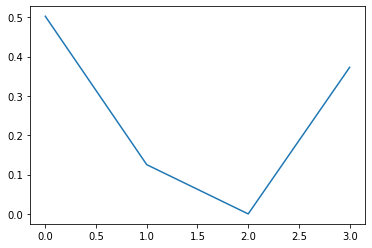

In [10]:
example_idx = -4

plt.plot(weights[example_idx])

for example_idx in range(num_samples): 
    print(x[example_idx], label[example_idx])
    plt.plot(weights[example_idx])

tensor([7.1184]) tensor([2.9833])
tensor([0.3838]) tensor([2.6035])
tensor([6.3754]) tensor([2.0714])
tensor([2.5332]) tensor([-0.1942])
tensor([7.5719]) tensor([2.7631])
tensor([6.8802]) tensor([2.8552])
tensor([3.0127]) tensor([-1.5484])
tensor([7.4765]) tensor([2.8591])
tensor([5.8895]) tensor([0.8253])
tensor([5.9965]) tensor([1.1273])


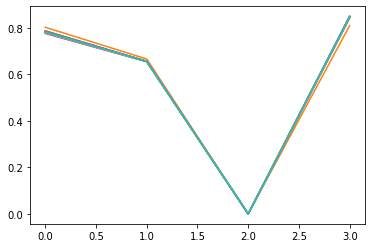

In [11]:
for example_idx in range(num_samples): 
    print(x[example_idx], label[example_idx])
    plt.plot(std[example_idx])
# plt.ylim(0, 1.2)

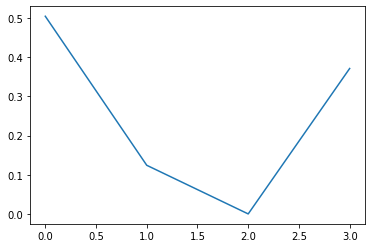

In [12]:
mu[-1], weights[-1]

plt.plot(weights[-1])

In [13]:
weights

array([[5.07724822e-01, 1.22796781e-01, 2.22512018e-08, 3.69478434e-01],
       [4.83159095e-01, 1.04860574e-01, 8.66774528e-08, 4.11980301e-01],
       [5.05632341e-01, 1.23710059e-01, 2.40353781e-08, 3.70657682e-01],
       [5.01151383e-01, 1.25678957e-01, 2.83464292e-08, 3.73169601e-01],
       [5.09019494e-01, 1.22233704e-01, 2.12136726e-08, 3.68746787e-01],
       [5.07044435e-01, 1.23093270e-01, 2.28164403e-08, 3.69862229e-01],
       [5.02323270e-01, 1.25162274e-01, 2.71501026e-08, 3.72514457e-01],
       [5.08747160e-01, 1.22352026e-01, 2.14278764e-08, 3.68900836e-01],
       [5.04302979e-01, 1.24292262e-01, 2.52416079e-08, 3.71404737e-01],
       [5.04595697e-01, 1.24163896e-01, 2.49709675e-08, 3.71240407e-01]],
      dtype=float32)

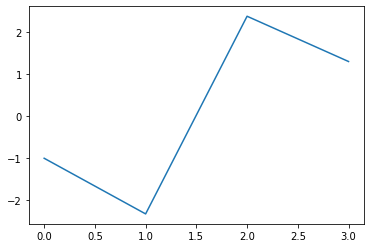

In [14]:
plt.plot(mu[example_idx])

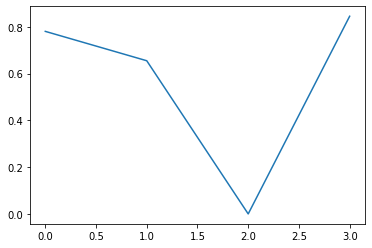

In [15]:
plt.plot(std[example_idx])

In [16]:
label[example_idx], x[example_idx]

(tensor([1.1273]), tensor([5.9965]))

In [33]:

num_samples=20
with_noise=False
noise_dev=1
input_range=[-5.0, 5.0]
lr_inner = 0.01
k = 5
extract_task_info = True

test_waves = dataset.get_meta_test_batch(task_batch_size=num_eval)
wave = test_waves[4]

losses, task_info = eval_for_plotting_mixture(model,wave,lr_inner,k, num_samples=num_samples, with_noise=with_noise, 
                  noise_dev=noise_dev, input_range=input_range,
                 extract_task_info=extract_task_info)
    
    

pred_data:  [(-4.997061, -0.074994184, 0.19393516), (-4.9959483, -0.07499367, 0.19393456), (-4.9959064, -0.07499368, 0.19393453), (-4.993627, -0.074992664, 0.19393332), (-4.993359, -0.07499258, 0.19393317), (-4.99303, -0.074992456, 0.19393304), (-4.992681, -0.07499229, 0.19393282), (-4.992541, -0.07499228, 0.19393277), (-4.991397, -0.07499178, 0.19393215), (-4.991113, -0.07499164, 0.19393203), (-4.990604, -0.074991435, 0.19393173), (-4.990252, -0.07499128, 0.19393158), (-4.9899383, -0.07499117, 0.1939314), (-4.9899263, -0.074991144, 0.19393137), (-4.9893665, -0.07499093, 0.19393109), (-4.989273, -0.07499088, 0.19393104), (-4.98918, -0.07499082, 0.19393097), (-4.9890466, -0.074990764, 0.19393092), (-4.988615, -0.0749906, 0.1939307), (-4.98482, -0.07498902, 0.1939287), (-4.982914, -0.074988194, 0.19392768), (-4.9820766, -0.074987836, 0.19392724), (-4.9817767, -0.07498771, 0.19392708), (-4.981168, -0.07498747, 0.19392678), (-4.9805784, -0.07498723, 0.19392648), (-4.9802012, -0.07498709, 0

<ipython-input-2-d74246e4c852>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x[:,None])
<ipython-input-2-d74246e4c852>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(y_true[:,None])
/Users/kcollins/mlmi4_MAML_reproduce/models.py:126: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = self.softmax(x[:,int(2*self.output_size/3):self.output_size])


In [38]:
wave.weighting

0.11083387195132731

<ipython-input-34-4404a6067e04>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ax.plot(np.array(func_gt)[:,0], np.array(func_gt)[:,1], label="Ground Truth")
<ipython-input-34-4404a6067e04>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ax.plot(np.array(true_vals)[:,0], np.array(true_vals)[:,1], '*', label="Observations", color="blue")


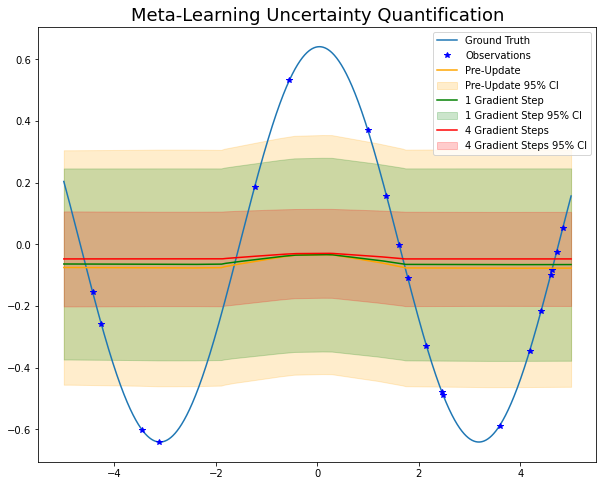

In [34]:
# fig, ax = plt.subplots(1,2, figsize=(16,6))
# fig.suptitle(title, fontsize=title_size + 3)

fig, ax = plt.subplots(figsize=(10,8))
num_k_shots = k
true_vals = task_info["gt"]
func_gt = task_info["gt_func"]
func_prior = task_info["preds_0"]
updated_func_single = task_info["preds_1"]
updated_func_many = task_info[f"preds_{num_k_shots-1}"]


ax.plot(np.array(func_gt)[:,0], np.array(func_gt)[:,1], label="Ground Truth")
ax.plot(np.array(true_vals)[:,0], np.array(true_vals)[:,1], '*', label="Observations", color="blue")


labels = ["Pre-Update", "1 Gradient Step", f"{num_k_shots-1} Gradient Steps"]
colors = ["orange", "green", "red"]
vals = [func_prior, updated_func_single, updated_func_many]
for label, color, pred_data in zip(labels, colors, vals): 
    sorted_x = np.array(pred_data)[:,0]
    pred_mu = np.array(pred_data)[:,1]
    pred_std = np.array(pred_data)[:,2]
    ax.plot(sorted_x, pred_mu, label=label, color=color)
    # confidence interval plotting help from: https://stackoverflow.com/questions/59747313/how-to-plot-confidence-interval-in-python
    # and: https://stackoverflow.com/questions/22481854/plot-mean-and-standard-deviation
    # and: https://stackoverflow.com/questions/12957582/plot-yerr-xerr-as-shaded-region-rather-than-error-bars
    ci = 1.96 * pred_std
    ax.fill_between(sorted_x, pred_mu - ci, pred_mu+ ci, alpha=.2,label=f"{label} 95% CI",color=color)
    
# ax.plot(np.array(updated_func_single)[:,0], np.array(updated_func_single)[:,1], label="1 Gradient Step", color="green")
# ax.plot(np.array(updated_func_many)[:,0], np.array(updated_func_many)[:,1], label=f"{num_k_shots-1} Gradient Steps", color="red")

ax.set_xlabel("",fontsize=ax_size)
ax.set_ylabel("",fontsize=ax_size)
ax.set_title(f"Meta-Learning Uncertainty Quantification",fontsize=title_size)
# ax.set_ylim(plot_lims)
ax.legend(fontsize=10)#loc=legend_locs[idx],fontsize=10)


In [39]:
wave.amplitude1, wave.amplitude2

(0.3755572792149874, 0.6752654520203479)

In [36]:
test_wave.amplitude2

1.51553988665715

In [32]:
for wave in test_waves:
    print(wave.weighting)

0.5218747648424504
0.940334003961958
0.5168555017336218
0.24843553266672477
0.8071592009289456
0.8162938267830356
0.04804980338278363
0.21129623136057282
0.5450573509358274
0.4718977886863457
0.9592369738525556
0.7007069153167053
0.33781186804610486
0.9289505947625512
0.5576974168522008
0.6382898380473265
0.9018800575784606
0.2648033059096869
0.5618552999743641
0.0005702007633798545
0.30833603845663626
0.5462100664159133
0.928518165746296
0.40532313414954546
0.9969515529730972
0.035776676573863665
0.025769117247142526
0.08822700733833785
0.45543043911315045
0.018805679143864128
0.3446011434855536
0.9772050661844467
0.6659791270506817
0.34195582640008515
0.17820200787791837
0.11411271663098048
0.06239618246011356
0.5185971300692722
0.7501316972199226
0.14392585857902232
0.5751988314203038
0.7330549261382642
0.8511159251067585
0.8273534853677743
0.8710192704122515
0.19224401074721564
0.625655948756832
0.21038015002788427
0.6668813013063092
0.796362497667428
0.8118017475111395
0.434377853